This notebook have solutions for chapter 3 of the book Statistical Rethinking Second Edition in Python. 

 If you need solutions in R language you can follow another material, such as [wjakethompson](https://sr2-solutions.wjakethompson.com/linear-models-causal-inference.html), [xcelab](http://xcelab.net/rmpubs/rethinking/rethinking_solutions_2.pdf) or [erikkusch](https://www.erikkusch.com/courses/rethinking/chapter-02/).

Config

In [32]:
import os
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")


These problems use the samples from the posterior distribution for the globe tossing example.
This code will give you a specific set of samples, so that you can check your answers exactly.

In [33]:
n=1000
prior = jnp.repeat(1,n)
total_tosses = 9 
ocurrences = 6 
n_samples = 10000

p_grid = jnp.linspace(start=0, stop=1, num=n)
likelihood = jnp.exp(dist.Binomial(total_count=total_tosses, probs = p_grid).log_prob(ocurrences))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n_samples,))
samples = p_grid[id_samples]

#### 3E1

How much posterior probability lies below p = 0.2?

In [34]:
samples[samples<0.2]

DeviceArray([0.18218218, 0.1951952 , 0.1961962 , 0.16216215, 0.17917918,
             0.16216215, 0.15215215, 0.18118118, 0.18618618],            dtype=float32)

In [35]:
below_02 =(samples<0.2).sum()/len(samples)
print(f'{below_02:.4f} % of posterior probability lies below 0.2')

0.0009 % of posterior probability lies below 0.2


#### 3E2

How much posterior probability lies above p = 0.8?

In [36]:
below_08 = jnp.sum(posterior[p_grid>0.8])
print(f'{below_08:.2f} % of posterior probability lies below 0.8')

0.12 % of posterior probability lies below 0.8


#### 3E3

How much posterior probability lies between p = 0.2 and p = 0.8?

In [37]:
btw_08_02 = jnp.sum(posterior[(p_grid<0.8) & (p_grid>0.2)])

print(f'{btw_08_02:.2f} % of posterior probability is between 0.2 and 0.8')

0.88 % of posterior probability is between 0.2 and 0.8


#### 3E4

20% of the posterior probability lies below which value of p?

In [38]:
p = jnp.quantile(samples, 0.2)

print(f'20% of posterior probabily lies below {p:.2f}')

20% of posterior probabily lies below 0.52


#### 3E5

 20% of the posterior probability lies above which value of p?

In [39]:
p = jnp.quantile(samples, 0.8)
print(f'20% of posterior probabily lies above {p:.2f}')

20% of posterior probabily lies above 0.76


#### 3E6

Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [40]:
numpyro.diagnostics.hpdi(samples, 0.66)

start = (1-0.66)/2
end = start + 0.66
start_interval, end_interval = jnp.quantile(samples, jnp.array([start, end]))

print(f'The HDPI interval lies between {start_interval:.2f} and {end_interval:.2f}')

The HDPI interval lies between 0.50 and 0.78


#### 3E7

Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [41]:
start = (1-0.66)/2
end = start + 0.66

#### 3M1

Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

In [42]:
n=1000
prior = jnp.repeat(1,n)
total_tosses = 15 
ocurrences = 8
n_samples = 10000

p_grid = jnp.linspace(start=0, stop=1, num=n)
likelihood = jnp.exp(dist.Binomial(total_count=total_tosses, probs = p_grid).log_prob(ocurrences))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n_samples,))
samples = p_grid[id_samples]

([], [])

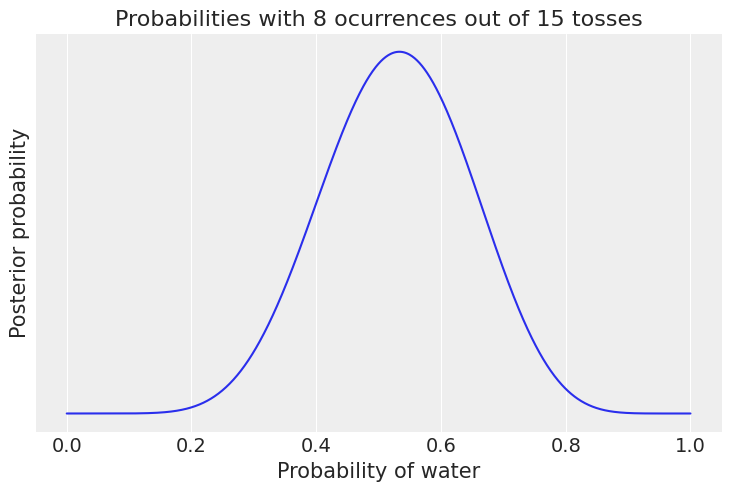

In [43]:
plt.plot(p_grid,posterior)
plt.title('Probabilities with 8 ocurrences out of 15 tosses')
plt.xlabel('Probability of water')
plt.ylabel('Posterior probability')
plt.yticks([])

#### 3M2

Draw 10,000 samples from the grid approximation from above. Then use the samples to cal-
culate the 90% HPDI for p.

In [44]:
jnp.mean(numpyro.diagnostics.hpdi(samples, 0.90))

DeviceArray(0.5315315, dtype=float32)

#### 3M3

Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?

the probability of observing 8 water in 15 tosses is 0.14


Text(0.5, 0, 'Number of water observed in 15 tosses')

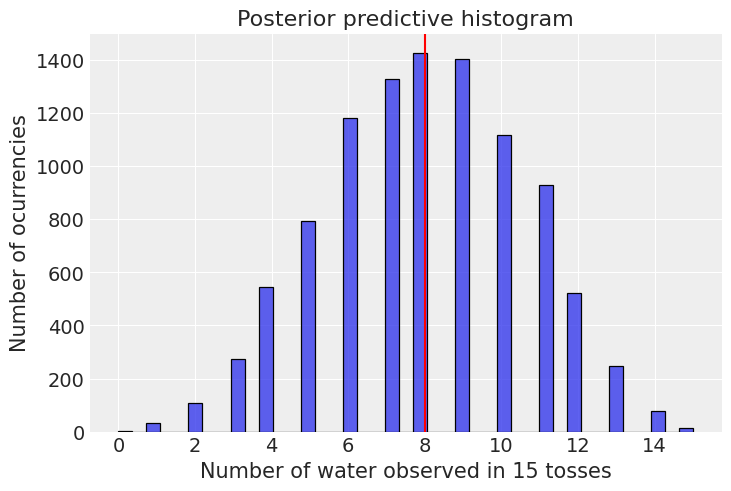

In [45]:
posterior_pred_sim = dist.Binomial(total_count=total_tosses, probs = samples).sample(random.PRNGKey(0))
prob = (posterior_pred_sim==ocurrences).sum()/(len(posterior_pred_sim))
print(f'the probability of observing 8 water in 15 tosses is {prob:.2f}')

sns.histplot(posterior_pred_sim)
plt.axvline(8, color='r')
plt.title('Posterior predictive histogram')
plt.ylabel('Number of ocurrencies')
plt.xlabel('Number of water observed in 15 tosses')

#### 3M4

Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [46]:
total_tosses = 9
ocurrences = 6

posterior_pred_sim = dist.Binomial(total_count=total_tosses, probs = samples).sample(random.PRNGKey(0))
prob = (posterior_pred_sim==ocurrences).sum()/n_samples

print(f'the probability of observing 6 water in 9 tosses is {prob:.2f}')

the probability of observing 6 water in 9 tosses is 0.18


#### 3M5

Start over at 3M1, but now use a prior that is zero below p =0.5 and a constant above p =0.5. This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each problem above and compare the inferences. What difference does the better prior make? If it helps, compare inferences (using both priors) to the true value p =0.7.


In [47]:
n = 1000
p_grid = jnp.linspace(start=0, stop=1, num=n)
prior = jnp.repeat(1,n)
prior = prior.at[p_grid<0.5].set(0)

likelihood = jnp.exp(dist.Binomial(total_count=15, probs = p_grid).log_prob(8))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)

##### 3M1 with new prior

the center off mass of probability is moved to right


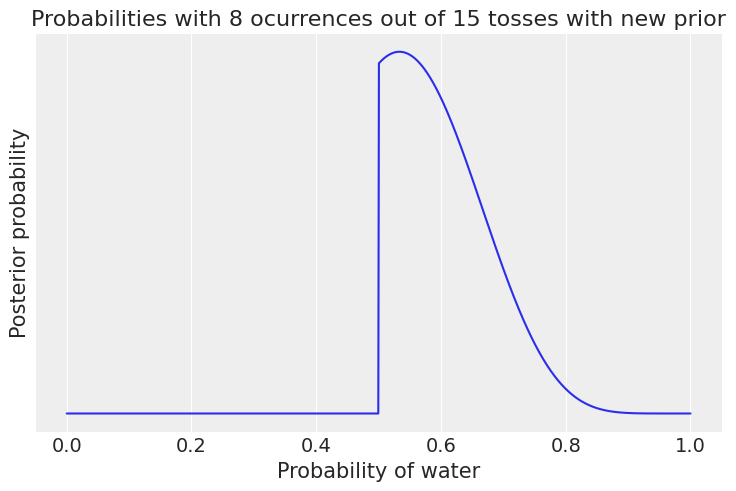

In [48]:

plt.title('Probabilities with 8 ocurrences out of 15 tosses with new prior')
plt.plot(p_grid,posterior)
plt.yticks([])
plt.ylabel('Posterior probability')
plt.xlabel('Probability of water')
print('the center off mass of probability is moved to right')


##### 3M2 with new prior

In [49]:
id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n,))
samples = p_grid[id_samples]
jnp.mean(numpyro.diagnostics.hpdi(samples, 0.90))

print('the 90% HPDI is .60 and it was .53 with flat prior.')

the 90% HPDI is .60 and it was .53 with flat prior.


##### 3M3 with new prior


the probability of observing 8 water in 15 tosses is 0.07. It was .14 with flat prior.


Text(0.5, 0, 'Number of water observed in 15 tosses')

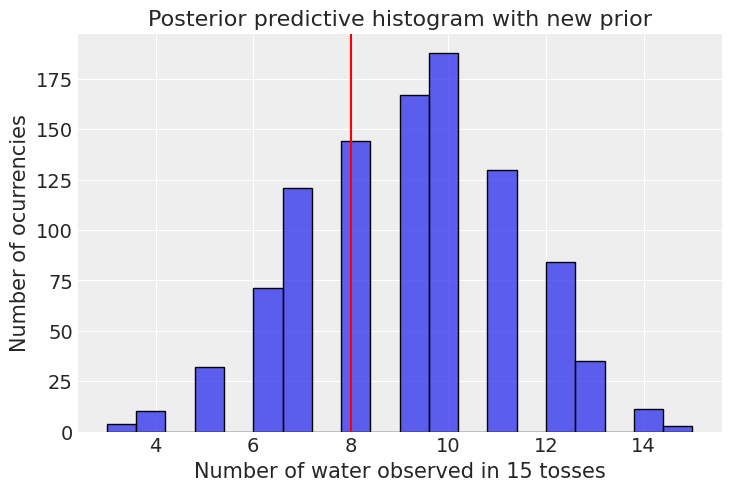

In [50]:
total_tosses = 15
posterior_pred_sim = dist.Binomial(total_count=total_tosses, probs = samples).sample(random.PRNGKey(0))
prob = (posterior_pred_sim==ocurrences).sum()/(len(posterior_pred_sim))
print(f'the probability of observing 8 water in 15 tosses is {prob:.2f}. It was .14 with flat prior.')

sns.histplot(posterior_pred_sim)
plt.axvline(8, color='r')

plt.title('Posterior predictive histogram with new prior')
plt.ylabel('Number of ocurrencies')
plt.xlabel('Number of water observed in 15 tosses')

##### 3M4 with new prior


In [51]:
total_tosses = 9
ocurrences = 6

posterior_pred_sim = dist.Binomial(total_count=total_tosses, probs = samples).sample(random.PRNGKey(0))
prob = (posterior_pred_sim==ocurrences).sum()/n_samples

print(f'the probability of observing 6 water in 9 tosses is {prob:.2f} and it was .18')

the probability of observing 6 water in 9 tosses is 0.02 and it was .18


##### 3M6

 Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this?

In [52]:
def grid_approximation(n_tosses:int) -> jnp.array:
    """Apply grid approximation method considering a binomial distribution with p=0.7 and flat prior.

    Args:
        n_tosses (int): number of glob tosses.

    Returns:
        jnp.array: sample of obverved p´s.
    """    
    
    p_grid = jnp.linspace(start=0, stop=1, num=1000)
    prior = jnp.repeat(1,n)
    likelihood = jnp.exp(dist.Binomial(total_count=n_tosses,
                                       probs = p_grid)
                                       .log_prob(int(n_tosses*0.7))
                                       )
    posterior = likelihood * prior
    id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n_samples,))
    samples = p_grid[id_samples]

    return samples

n_tosses = 2000 #initial guess
dif_hpdi = 1
while dif_hpdi>0.05:
    samples = grid_approximation(n_tosses)
    hpdi_interval = numpyro.diagnostics.hpdi(samples, 0.99)
    dif_hpdi = hpdi_interval[1] - hpdi_interval[0]
    n_tosses = n_tosses + 1


print(f'Approximate {n_tosses} tosses that gives a hpdi_interval of {dif_hpdi} wide.')

Approximate 2231 tosses that gives a hpdi_interval of 0.0490490198135376 wide.


Introduction Hard Exercises:
The practice problems here all use the data below. These data indicate the gender(male=1, female=0) of officially reported first and second born children in 100 two-child families

In [53]:
#3H
birth1 = jnp.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,
1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,
1,0,1,1,1,0,1,1,1,1])

birth2 = jnp.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

total_boys = jnp.sum(birth1 + birth2)


##### 3H1


Using grid approximation, compute the posterior distribution for the probability of a birth being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?


Text(0.5, 0, 'Probability of a birth being a boy')

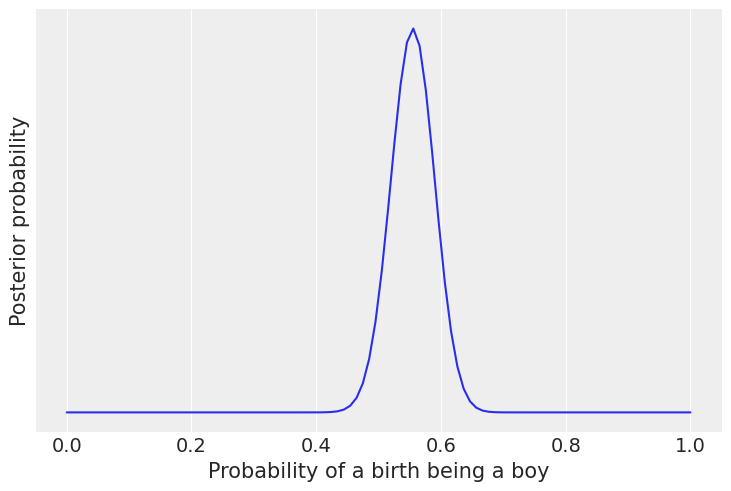

In [54]:
n=100
p_grid = jnp.linspace(start=0, stop=1, num=n)
prior = jnp.repeat(1,n)
total_ocurrencies = birth1.shape[0] + birth2.shape[0]

likelihood = jnp.exp(dist.Binomial(total_count=total_ocurrencies, probs = p_grid).log_prob(total_boys))

posterior = likelihood * prior
posterior = posterior/(posterior.sum())
plt.plot(p_grid,posterior)
plt.yticks([])
plt.ylabel('Posterior probability')
plt.xlabel('Probability of a birth being a boy')

In [55]:
print(f'A value of {p_grid[posterior==posterior.max()][0]:.2f}')


A value of 0.56


##### 3H2

Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior density intervals.

In [56]:
n_samples=10000
id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n_samples,))
samples = p_grid[id_samples]

for hpd in [.50,.89,.97]:    
    hpdi_interval = numpyro.diagnostics.hpdi(samples, hpd)
    print(f'Interval of hpd {hpd}: {hpdi_interval}')

Interval of hpd 0.5: [0.5252525  0.56565654]
Interval of hpd 0.89: [0.4949495 0.6060606]
Interval of hpd 0.97: [0.47474748 0.6262626 ]


##### 3H3

Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to visualize the simulations, but the dens command (part of the rethinking package) is probably the easiest way in this case. Does it look like the model fits the data well? That is, does the distribution of predictions include the actual observation as a central, likely outcome?

The fit of the model in data seems reasonable as expected value of simulations and results are very close and inside the 30% hdpi interval.


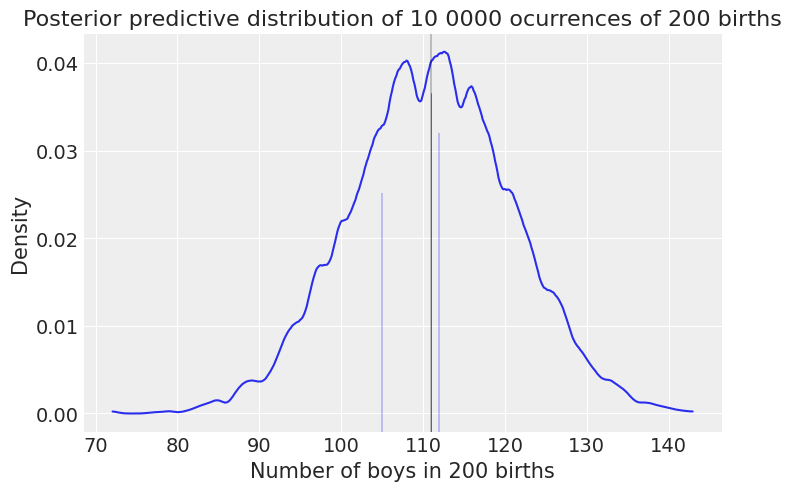

In [57]:
total_boys_simulated_births = dist.Binomial(total_count=200, probs = samples).sample(random.PRNGKey(0), (1,))

# Max HDPI 90% for de 10 0000 simulations
hpdi_interval = numpyro.diagnostics.hpdi(total_boys_simulated_births.flatten(), 0.30)


az.plot_kde(values=total_boys_simulated_births, bw=0.7)
plt.axvline(x = hpdi_interval[0], ymax = 0.6, ymin = 0, linewidth=0.3 ,color = 'b') # min of 30% HDPI interval
plt.axvline(x = hpdi_interval[1], ymax = 0.75, ymin = 0, linewidth=0.3 ,color = 'b') # max of 30% HDPI interval
plt.axvline(x = total_boys, ymax = 0.85, ymin = 0, linewidth=0.5 ,color = 'r') # Observed value
plt.axvline(x = total_boys_simulated_births.mean(), ymax = 1, ymin = 0, linewidth=0.3 ,color = 'black') # median
plt.title('Posterior predictive distribution of 10 0000 ocurrences of 200 births')
plt.xlabel('Number of boys in 200 births')
plt.ylabel('Density')

print('The fit of the model in data seems reasonable as expected value of simulations and results are very close and inside the 30% hdpi interval.')



##### 3H4

Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys in the first births, birth1. How does the model look in this light?


The model still seem to fit the data.


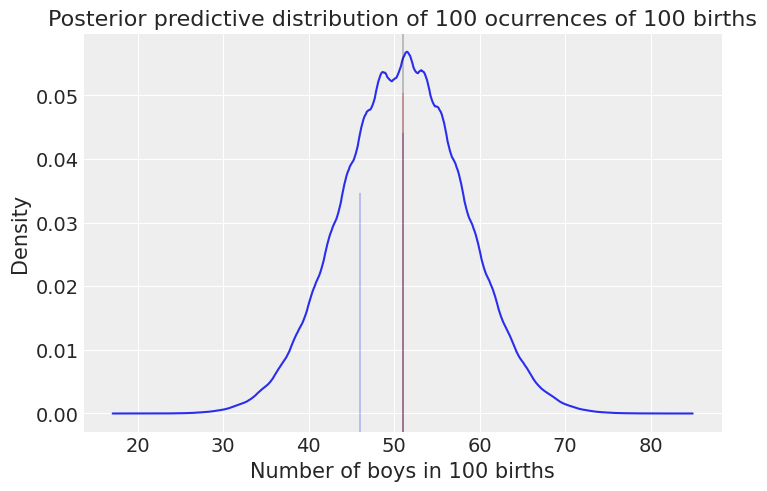

In [58]:

n=100
p_grid = jnp.linspace(start=0, stop=1, num=n)
prior = jnp.repeat(1,n)
total_ocurrencies = birth1.shape[0]

likelihood = jnp.exp(dist.Binomial(total_count=total_ocurrencies, probs = p_grid).log_prob(birth1.sum()))

posterior = likelihood * prior
posterior = posterior/(posterior.sum())

n_samples=10000
id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n_samples,))
samples = p_grid[id_samples]

posterior_pred_sim_ids = dist.Binomial(total_count=100, probs = samples).sample(random.PRNGKey(0), (100,))

# Max HDPI 90% for de 10 0000 simulations
hpdi_interval = numpyro.diagnostics.hpdi(posterior_pred_sim_ids.flatten(), 0.30)


az.plot_kde(values=posterior_pred_sim_ids, bw=0.7)
plt.axvline(x = hpdi_interval[0], ymax = 0.6, ymin = 0, linewidth=0.3 ,color = 'b') # min of 60% HDPI interval
plt.axvline(x = hpdi_interval[1], ymax = 0.75, ymin = 0, linewidth=0.3 ,color = 'b') # max of 60% HDPI interval
plt.axvline(x = birth1.sum(), ymax = 0.85, ymin = 0, linewidth=0.3 ,color = 'r') # Observed value
plt.axvline(x = posterior_pred_sim_ids.mean(), ymax = 1, ymin = 0, linewidth=0.3 ,color = 'black') # median
plt.title('Posterior predictive distribution of 100 ocurrences of 100 births')
plt.xlabel('Number of boys in 100 births')
plt.ylabel('Density')

print('The model still seem to fit the data.')


##### 3H5

The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts of boys to only those second births that followed girls. To do this correctly, you need to count the number of first borns who were girls and simulate that many births, 10,000 times. Compare the counts of boys in your simulations to the actual observed count of boys following girls. How does the model look in this light? Any guesses what is going on in these data?


In [59]:
# second births that followed female first borns
total_boys = jnp.sum(birth2[birth1==0])
total_ocurrencies = len(birth2[birth1==0])

Text(0, 0.5, 'Density')

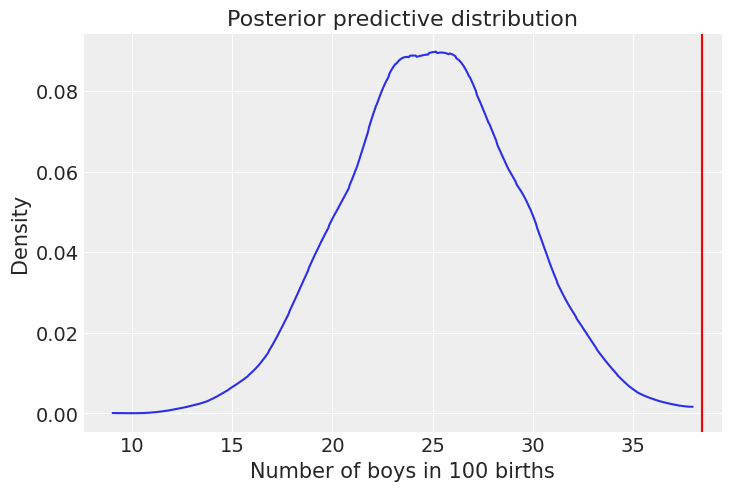

In [61]:
# calculating posteriori
likelihood = jnp.exp(dist.Binomial(total_count=total_ocurrencies, probs = p_grid).log_prob(total_boys))
posterior = likelihood * prior
posterior = posterior/(posterior.sum())

n_samples=10000
id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n_samples,))
samples = p_grid[id_samples]
posterior_predictive_sim = dist.Binomial(total_count=total_ocurrencies, probs = samples).sample(random.PRNGKey(0), (200,))
hpdi_interval = numpyro.diagnostics.hpdi(posterior_pred_sim_ids.flatten(), 0.60)
posterior_predictive_sim_mean = posterior_predictive_sim.mean()



# Distribution dont considering sex first
likelihood = jnp.exp(dist.Binomial(total_count=len(birth1), probs = p_grid).log_prob(birth1.sum()))
posterior = likelihood * prior
posterior = posterior/(posterior.sum())
id_samples = dist.Categorical(probs = posterior).sample(random.PRNGKey(0), (n_samples,))
samples = p_grid[id_samples]

total_boys_simulated_births = dist.Binomial(total_count=total_ocurrencies, probs = samples).sample(random.PRNGKey(0), (1,))

az.plot_kde(values=total_boys_simulated_births, bw=0.7)
plt.axvline(posterior_predictive_sim_mean, color='r')
plt.title('Posterior predictive distribution')
plt.xlabel('Number of boys in 100 births')
plt.ylabel('Density')
#TODO write axis labels

It seems the data does not represent the binomial model as the model does not seem to fit to the data. The events are dependent, they follow another distribution or there was not enough data.  